In [2]:
import datetime

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, plot_importance

import nflpp

In [3]:
%%capture
pbp_data = nflpp.load_pbp_data(range(1999, 2024))

In [4]:
processed_data = pbp_data[pbp_data["play_type"].isin(["run", "pass"])]

print(f"Run/pass filtered shape: {processed_data.shape}")

Run/pass filtered shape: (839562, 390)


In [5]:
columns = [
    # Target
    "play_type",
    # Features
    "drive",
    "qtr",
    "quarter_seconds_remaining",
    "down",
    "ydstogo",
    "yardline_100",
    "shotgun",
    "no_huddle",
    "score_differential",
    "spread_line",
    "season",
    "posteam",
    # Used to create poscoach
    "home_coach",
    "away_coach",
    "home_team",
    "away_team",
]
processed_data = processed_data[columns]
print(f"Run/pass filtered shape: {processed_data.shape}")

Run/pass filtered shape: (839562, 17)


In [6]:
processed_data.loc[:, "poscoach"] = processed_data.apply(
    lambda row: row["home_coach"]
    if row["posteam"] == row["home_team"]
    else row["away_coach"],
    axis=1,
)
processed_data = processed_data.drop(
    columns=["home_coach", "away_coach", "home_team", "away_team"]
)
print(f"Post-poscoach shape: {processed_data.shape}")

Post-poscoach shape: (839562, 14)


In [7]:
for column in ("posteam", "poscoach", "play_type"):
    processed_data[column] = LabelEncoder().fit_transform(processed_data[column])

In [8]:
train_data = processed_data[processed_data["season"] < 2022]
test_data = processed_data[processed_data["season"] == 2022]
validation_data = processed_data[processed_data["season"] == 2023]

In [9]:
train_features, train_target = (
    train_data.drop("play_type", axis=1),
    train_data["play_type"],
)
test_features, test_target = (
    train_data.drop("play_type", axis=1),
    train_data["play_type"],
)

In [10]:
clf = XGBClassifier()
clf.fit(train_features.values, train_target)
test_preds = clf.predict(test_features.values)
accuracy = accuracy_score(test_target, test_preds)
f1_score = f1_score(test_target, test_preds)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1_score:.2f}")

Accuracy: 73.23%
F1 Score: 0.69


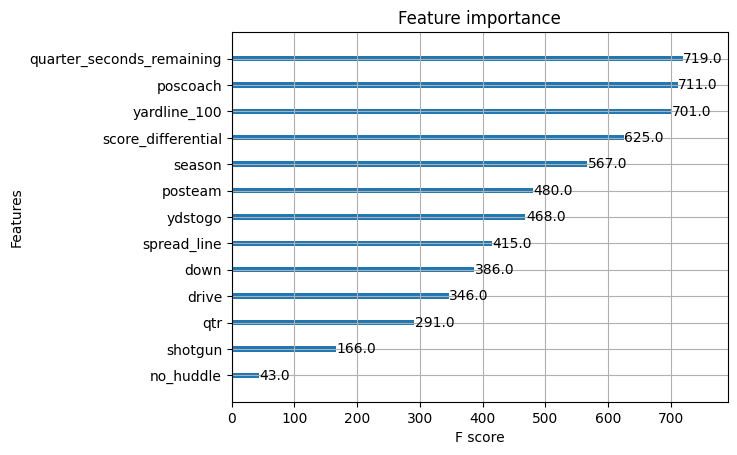

In [11]:
clf.get_booster().feature_names = train_features.columns.tolist()

plot_importance(clf)
plt.show()

In [12]:
models_directory = "../models"

version = 3.1
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"{models_directory}/xgboost_v{version}_{timestamp}_{accuracy:.4f}.json"

clf.save_model(filename)